# ENVI Tutorial:

### What is COVET?

COVET is a method for representing and quantifying cellular niches based on their gene-gene covariance. COVET takes as input spatial data and returns the niche gene-gene covariance matrix of each cell.


### What is ENVI?
ENVI integrates between paired scRNA-seq and spatial data. ENVI relies on COVET and predicts spatial context of dissociated scRNA-seq data & imputes missing genes for the spatial data. ENVI takes as input spatial data and scRNA_seq data, trains a VAE model and produces latent embeddings for each dataset, imputed values for the spatial data, and predicted COVET matrices for the scRNA-seq data.


***
# Setting Up
ENVI is based on tensorflow and scanpy. This tutorial installs the ENVI package (which includes COVET), and the following dependencies:
- sklearn
- scipy
- scanpy
- phenograph
- tensorflow (Apple Silicon Mac users need to manually install their specific tensorflow, https://developer.apple.com/metal/tensorflow-plugin/)
- tensorflow_probability

For this tutorial to run, the following packages are also required and need to be pre-installed:
- harmonyTS (https://github.com/dpeerlab/Harmony)
- colorcet (very useful for plotting)


In [1]:
!git clone https://github.com/bhargavchippada/forceatlas2; cd forceatlas2; pip install .; cd ..; rm -rf forceatlas2
!pip install harmonyTS
!pip install colorcet

Cloning into 'forceatlas2'...
remote: Enumerating objects: 232, done.
remote: Total 232 (delta 0), reused 0 (delta 0), pack-reused 232
Receiving objects: 100% (232/232), 741.79 KiB | 1.73 MiB/s, done.
Resolving deltas: 100% (131/131), done.
Processing /Users/tdougherty/Desktop/peerlab/ENVI/forceatlas2
  Preparing metadata (setup.py) ... done
  Created wheel for fa2: filename=fa2-0.3.5-cp310-cp310-macosx_10_9_x86_64.whl size=152208 sha256=0fdd5c0fe6e95760e8b7a9d1e862ffee5afffea95f3f889e302465cddf64d9a7
  Stored in directory: /private/var/folders/k9/29skmjzj03v7c5j7crb2n8w80000gn/T/pip-ephem-wheel-cache-m3wjzhzw/wheels/61/c4/1c/eae7aaf3c214351af8de71d8304cecfb12ac0f5f2ffe6cf535
Successfully built fa2
  Attempting uninstall: fa2
    Found existing installation: fa2 0.3.5
    Uninstalling fa2-0.3.5:
      Successfully uninstalled fa2-0.3.5


In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Change if you want to use GPU!

In [3]:
# Disable tensorflow warnings

import logging
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # FATA

warnings.filterwarnings("ignore")
logging.getLogger("tensorflow").setLevel(logging.FATAL)
logging.getLogger("tensorflow_probability").setLevel(logging.FATAL)


# Install ENVI

ENVI can be installed directly with pip with the following command:

In [4]:
!pip install -e .

Obtaining file:///Users/tdougherty/Desktop/peerlab/ENVI
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for scENVI (pyproject.toml) ... done
  Created wheel for scENVI: filename=scENVI-0.1.0-0.editable-py3-none-any.whl size=3302 sha256=f07eee304732b4b1e554fbc6f0bb4417acec2fe7a232bc94f18c58ce9489e47a
  Stored in directory: /private/var/folders/k9/29skmjzj03v7c5j7crb2n8w80000gn/T/pip-ephem-wheel-cache-u_8yir8j/wheels/bc/cb/a6/df187c5f5784324ccc91e683146506318bbf338eaaf0979a67
Successfully built scENVI
  Attempting uninstall: scENVI
    Found existing installation: scENVI 0.1.0
    Uninstalling scENVI-0.1.0:
      Successfully uninstalled scENVI-0.1.0


# Importing

In [5]:
from scENVI import ENVI

In [6]:
import numpy as np
import pandas as pd
import scanpy as sc
import colorcet
import sklearn.neighbors
import scipy.sparse
import harmony
import umap

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# Utility Functions:

Some functions that are used in the analysis in this tutorial, feel free to switch to you own preferred versions

In [8]:
def flatten(arr):
    return np.reshape(arr, [arr.shape[0], -1])


def run_diffusion_maps(data_df, n_components=10, k=30, alpha=0):
    """Run Diffusion maps using the adaptive anisotropic kernel
    :param data_df: PCA projections of the data or adjacency matrix
    :param n_components: Number of diffusion components
    :param k: Number of nearest neighbors for graph construction
    :param alpha: Normalization parameter for the diffusion operator
    :return: Diffusion components, corresponding eigenvalues and the diffusion operator
    """

    # Determine the kernel
    N = data_df.shape[0]

    if type(data_df).__module__ == np.__name__:
        data_df = pd.DataFrame(data_df)

    if not scipy.sparse.issparse(data_df):
        print("Determining nearest neighbor graph...")
        temp = sc.AnnData(data_df.values)
        sc.pp.neighbors(temp, n_pcs=0, n_neighbors=k)
        knn = temp.obsp["distances"]

        # Adaptive k
        adaptive_k = int(np.floor(k / 3))
        adaptive_std = np.zeros(N)

        for i in np.arange(len(adaptive_std)):
            adaptive_std[i] = np.sort(knn.data[knn.indptr[i] : knn.indptr[i + 1]])[
                adaptive_k - 1
            ]

        # Kernel
        x, y, dists = scipy.sparse.find(knn)

        # X, y specific stds
        dists = dists / adaptive_std[x]
        W = scipy.sparse.csr_matrix((np.exp(-dists), (x, y)), shape=[N, N])

        # Diffusion components
        kernel = W + W.T
    else:
        kernel = data_df

    # Markov
    D = np.ravel(kernel.sum(axis=1))

    if alpha > 0:
        # L_alpha
        D[D != 0] = D[D != 0] ** (-alpha)
        mat = scipy.sparse.csr_matrix((D, (range(N), range(N))), shape=[N, N])
        kernel = mat.dot(kernel).dot(mat)
        D = np.ravel(kernel.sum(axis=1))

    D[D != 0] = 1 / D[D != 0]
    T = scipy.sparse.csr_matrix((D, (range(N), range(N))), shape=[N, N]).dot(kernel)
    # Eigenvalue decomposition
    D, V = scipy.sparse.linalg.eigs(T, n_components, tol=1e-4, maxiter=1000)
    D = np.real(D)
    V = np.real(V)
    indices = np.argsort(D)[::-1]
    D = D[indices]
    V = V[:, indices]

    # Normalize
    for i in range(V.shape[1]):
        V[:, i] = V[:, i] / np.linalg.norm(V[:, i])

    # Create are results dictionary
    res = {"T": T, "EigenVectors": V, "EigenValues": D}
    res["EigenVectors"] = pd.DataFrame(res["EigenVectors"])
    if not scipy.sparse.issparse(data_df):
        res["EigenVectors"].index = data_df.index
    res["EigenValues"] = pd.Series(res["EigenValues"])
    res["kernel"] = kernel

    return res


def FDL(data, k=30):
    neighbors = sklearn.neighbors.NearestNeighbors(
        n_neighbors=int(k), metric="euclidean", n_jobs=5
    ).fit(data)
    knn = neighbors.kneighbors_graph(data, mode="distance")
    # Adaptive k

    adaptive_k = int(np.floor(k / 3))
    neighbors = sklearn.neighbors.NearestNeighbors(
        n_neighbors=int(adaptive_k), metric="euclidean", n_jobs=5
    ).fit(data)
    adaptive_std = neighbors.kneighbors_graph(data, mode="distance").max(axis=1)
    adaptive_std = np.ravel(adaptive_std.todense())
    # Kernel
    x, y, dists = scipy.sparse.find(knn)
    # X, y specific stds
    dists = dists / adaptive_std[x]
    N = data.shape[0]
    W = scipy.sparse.csr_matrix((np.exp(-dists), (x, y)), shape=[N, N])
    # Diffusion components
    kernel = W + W.T
    layout = harmony.plot.force_directed_layout(kernel)
    return layout


def ZeroOneNorm(arr):
    if arr.shape[0] > 1:
        return (arr - arr.min(axis=0, keepdims=True)) / (
            arr.max(axis=0, keepdims=True) - arr.min(axis=0, keepdims=True)
        )
    else:
        return arr


def normal_norm(arr, Clip=None):
    arr = np.asarray(arr)
    arr = (arr - arr.mean(axis=0, keepdims=True)) / (arr.std(axis=0, keepdims=True))
    if Clip != None:
        arr[arr < -Clip] = -Clip
        arr[arr > Clip] = Clip
    arr[np.isnan(arr)] = 0
    return arr


def smooth_signal(sig, n):
    n = n + int((n % 2 == 0))
    sig_pad = np.pad(sig, [(int(n / 2),)], mode="edge")
    sig_smooth = scipy.signal.convolve(sig_pad, np.asarray([1] * n).T / n, mode="valid")
    return sig_smooth

# Data

Downloading Motor Cortex scRNA-seq and MERFISH data from the Pe'er lab aws and loading in with scanpy

In [9]:
!wget -N https://dp-lab-data-public.s3.amazonaws.com/ENVI/sc_data.h5ad
!wget -N https://dp-lab-data-public.s3.amazonaws.com/ENVI/st_data.h5ad

--2023-05-09 14:08:44--  https://dp-lab-data-public.s3.amazonaws.com/ENVI/sc_data.h5ad
Resolving dp-lab-data-public.s3.amazonaws.com (dp-lab-data-public.s3.amazonaws.com)... 3.5.25.180, 3.5.27.104, 52.217.38.196, ...
Connecting to dp-lab-data-public.s3.amazonaws.com (dp-lab-data-public.s3.amazonaws.com)|3.5.25.180|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘sc_data.h5ad’ not modified on server. Omitting download.

--2023-05-09 14:08:45--  https://dp-lab-data-public.s3.amazonaws.com/ENVI/st_data.h5ad
Resolving dp-lab-data-public.s3.amazonaws.com (dp-lab-data-public.s3.amazonaws.com)... 3.5.25.180, 3.5.27.104, 52.217.38.196, ...
Connecting to dp-lab-data-public.s3.amazonaws.com (dp-lab-data-public.s3.amazonaws.com)|3.5.25.180|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘st_data.h5ad’ not modified on server. Omitting download.



In [10]:
sc_data = sc.read_h5ad("sc_data.h5ad")
st_data = sc.read_h5ad("st_data.h5ad")

Defining cell type color palette

In [11]:
cat_cmap = matplotlib.cm.get_cmap("cet_glasbey")
combined_cell_types = np.union1d(
    list(set(st_data.obs["cell_type"])), list(set(sc_data.obs["cell_type"]))
)

cell_type_palette = {ctype: cat_cmap(i) for i, ctype in enumerate(combined_cell_types)}
cell_label_palette = {
    ctype: cat_cmap(i) for i, ctype in enumerate(list(set(st_data.obs["cell_label"])))
}

cell_label_palette = {
    "GABAergic": (0.843137, 0.0, 0.0, 1.0),
    "Glutamatergic": (0.54902, 0.235294, 1.0, 1.0),
    "Non-Neuronal": (0.007843, 0.533333, 0.0, 1.0),
}

### Plotting the Motor Cortex MERFISH 

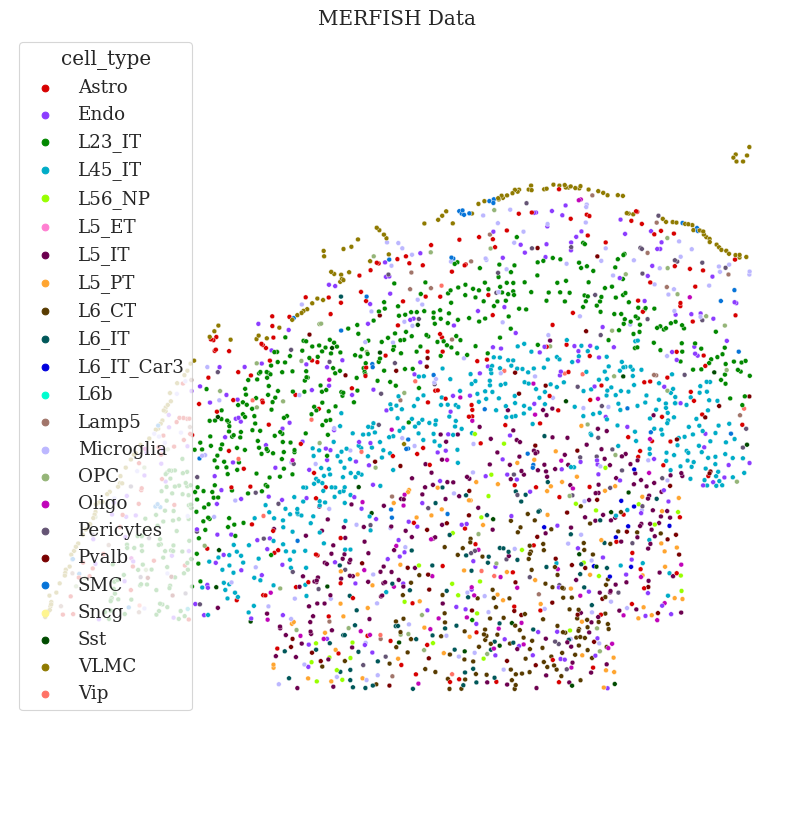

In [12]:
plt.figure(figsize=(10, 10))

sns.scatterplot(
    x=st_data.obsm["spatial"][st_data.obs["batch"] == "mouse1_slice10"][:, 1],
    y=-st_data.obsm["spatial"][st_data.obs["batch"] == "mouse1_slice10"][:, 0],
    legend=True,
    hue=st_data.obs["cell_type"][st_data.obs["batch"] == "mouse1_slice10"],
    s=12,
    hue_order=combined_cell_types,
    palette=cell_type_palette,
)
plt.axis("equal")
plt.axis("off")
plt.title("MERFISH Data")
plt.show()

### Plotting the Motor Cortex scRNAseq

In [13]:
fit = umap.UMAP(
    n_neighbors=100,
    min_dist=0.8,
    n_components=2,
)

sc_data.layers["log"] = np.log(sc_data.X + 1)
sc.pp.highly_variable_genes(sc_data, layer="log", n_top_genes=2048)
sc_data.obsm["UMAP_exp"] = fit.fit_transform(
    np.log(sc_data[:, sc_data.var["highly_variable"]].X + 1)
)

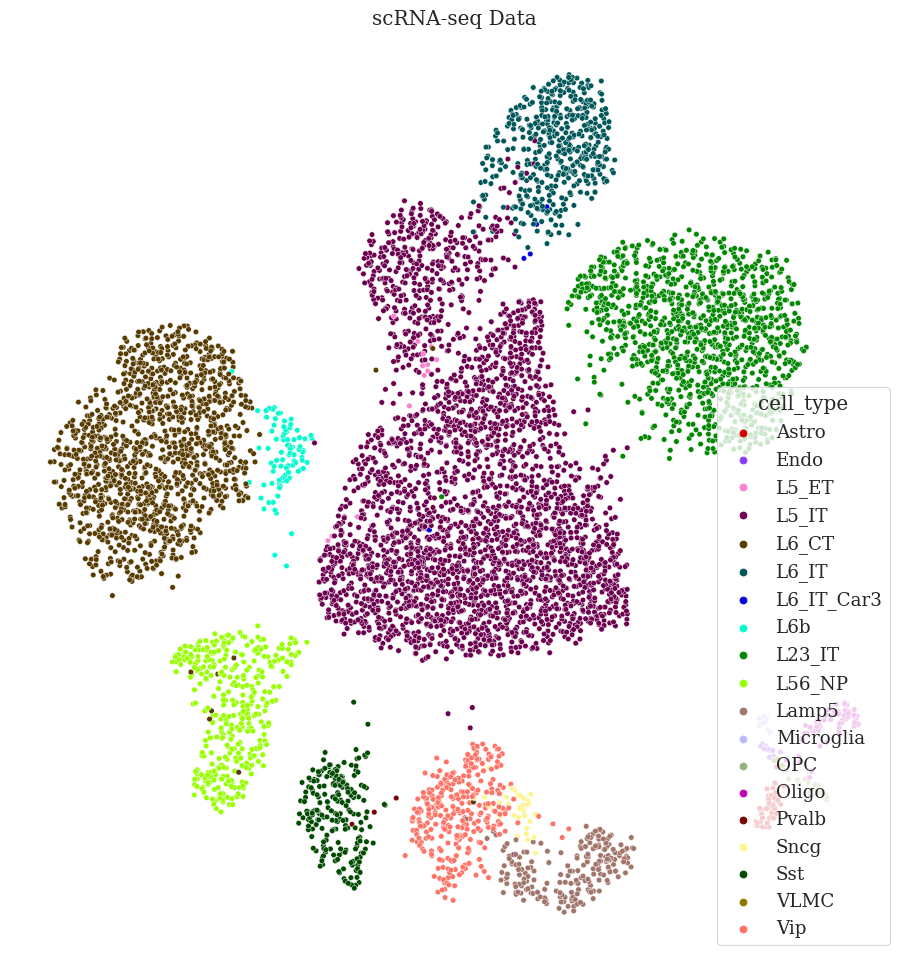

In [14]:
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=sc_data.obsm["UMAP_exp"][:, 0],
    y=sc_data.obsm["UMAP_exp"][:, 1],
    hue=sc_data.obs["cell_type"],
    s=16,
    palette=cell_type_palette,
    legend=True,
)
plt.tight_layout()
plt.axis("off")
plt.title("scRNA-seq Data")
plt.show()

# Running ENVI

We first define and ENVI model which computes the COVET matrices of the spatial data and initializes the CVAE:

In [15]:
ENVI_Model = ENVI.ENVI(spatial_data=st_data, sc_data=sc_data)

Computing COVET Matrices
Initializing VAE
Finished Initializing ENVI


In [21]:
ENVI_Model

Training ENVI and run auxiliary function

In [20]:
ENVI_Model.train()
ENVI_Model.impute()
ENVI_Model.infer_COVET()

Training ENVI for 16384 steps


Trn: spatial Loss: nan, SC Loss: nan, Cov Loss: nan, KL Loss: nan:   0%|          | 12/16384 [00:04<1:50:41,  2.47it/s]


KeyboardInterrupt: 

Read ENVI predictions

In [73]:
st_data.obsm["envi_latent"] = ENVI_Model.spatial_data.obsm["envi_latent"]
st_data.obsm["COVET"] = ENVI_Model.spatial_data.obsm["COVET"]
st_data.obsm["COVET_SQRT"] = ENVI_Model.spatial_data.obsm["COVET_SQRT"]
st_data.uns["COVET_genes"] = ENVI_Model.covet_genes
st_data.obsm["imputation"] = ENVI_Model.spatial_data.obsm["imputation"]


sc_data.obsm["envi_latent"] = ENVI_Model.sc_data.obsm["envi_latent"]
sc_data.obsm["COVET"] = ENVI_Model.sc_data.obsm["COVET"]
sc_data.obsm["COVET_SQRT"] = ENVI_Model.sc_data.obsm["COVET_SQRT"]
sc_data.uns["COVET_genes"] = ENVI_Model.covet_genes

### Plot UMAPs of ENVI latent

Double Checking that cell types co-embed from the MERFISH and scRNA-seq datasets

In [74]:
import umap

fit = umap.UMAP(
    n_neighbors=100,
    min_dist=0.1,
    n_components=2,
)

UMAPEmb = fit.fit_transform(
    np.concatenate([st_data.obsm["envi_latent"], sc_data.obsm["envi_latent"]], axis=0)
)

st_data.obsm["latent_umap"] = UMAPEmb[: st_data.shape[0]]
sc_data.obsm["latent_umap"] = UMAPEmb[st_data.shape[0] :]

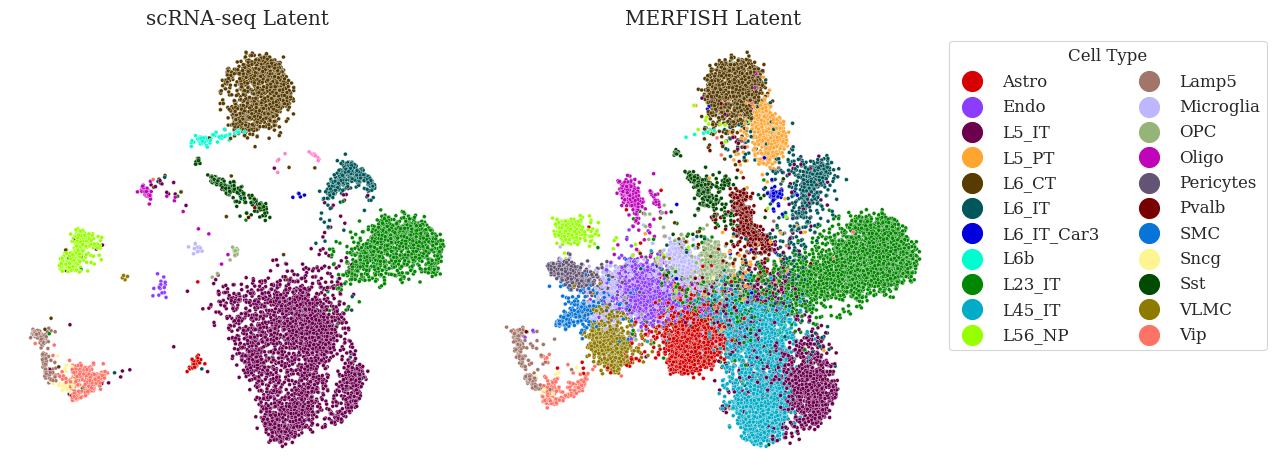

In [75]:
fig = plt.figure(figsize=(13, 5))
plt.subplot(121)
sns.scatterplot(
    x=sc_data.obsm["latent_umap"][:, 0],
    y=sc_data.obsm["latent_umap"][:, 1],
    hue=sc_data.obs["cell_type"],
    s=8,
    palette=cell_type_palette,
    legend=False,
)


# export_legend(legend, '/fscratch/havivd/ENVI_Figures/CortexMerFISH/cell_type_legend.svg')
plt.title("scRNA-seq Latent")
plt.axis("off")

plt.subplot(122)
sns.scatterplot(
    x=st_data.obsm["latent_umap"][:, 0],
    y=st_data.obsm["latent_umap"][:, 1],
    hue=st_data.obs["cell_type"],
    s=8,
    palette=cell_type_palette,
    legend=True,
)


legend = plt.legend(
    title="Cell Type",
    prop={"size": 12},
    fontsize="12",
    markerscale=3,
    ncol=2,
    bbox_to_anchor=(1, 1),
)  # , loc = 'lower left')
plt.setp(legend.get_title(), fontsize="12")
plt.title("MERFISH Latent")

plt.axis("off")
plt.tight_layout()
plt.show()

# ENVI COVET analysis:

- Zooming on the Glutamatergic neuron, and using their COVET embedding for pseudo-depth prediction

In [76]:
class_label = ["Glutamatergic"]

st_data_glut = st_data[np.isin(st_data.obs["cell_label"], class_label)].copy()
sc_data_glut = sc_data[np.isin(sc_data.obs["cell_label"], class_label)].copy()

### Calculating FDL and DC on COVET

- Note that we are running FDL on COVET_SQRT, this is because the distance between COVET matrices is the L2 between their SQRT. We can simply run FDL (or DC, UMAP, PhenoGraph, etc.) on the COVET_SQRT to analyze COVET niche representation!

In [77]:
fdl_covet = np.asarray(
    FDL(
        np.concatenate(
            [
                flatten(st_data_glut.obsm["COVET_SQRT"]),
                flatten(sc_data_glut.obsm["COVET_SQRT"]),
            ],
            axis=0,
        ),
        k=100,
    )
)

st_data_glut.obsm["FDL_COVET"] = fdl_covet[: st_data_glut.shape[0]]
sc_data_glut.obsm["FDL_COVET"] = fdl_covet[st_data_glut.shape[0] :]

100%|██████████| 500/500 [03:29<00:00,  2.39it/s]

BarnesHut Approximation  took  63.92  seconds
Repulsion forces  took  124.75  seconds
Gravitational forces  took  0.64  seconds
Attraction forces  took  14.87  seconds
AdjustSpeedAndApplyForces step  took  2.62  seconds


In [78]:
dc_covet = np.asarray(
    run_diffusion_maps(
        np.concatenate(
            [
                flatten(st_data_glut.obsm["COVET_SQRT"]),
                flatten(sc_data_glut.obsm["COVET_SQRT"]),
            ],
            axis=0,
        ),
        k=100,
    )["EigenVectors"]
)[:, 1:]
st_data_glut.obsm["DC_COVET"] = dc_covet[: st_data_glut.shape[0]]
sc_data_glut.obsm["DC_COVET"] = dc_covet[st_data_glut.shape[0] :]

Determining nearest neighbor graph...


### reverse DC if needed

- DC direction is arbitrary; so flip DC direction if it's backwards
- Should go from blue (shallow) to green (deep)

In [32]:
st_data_glut.obsm["DC_COVET"] = -dc_covet[: st_data_glut.shape[0]]
sc_data_glut.obsm["DC_COVET"] = -dc_covet[st_data_glut.shape[0] :]

#### Plot DC and Cell type on COVET FDL:

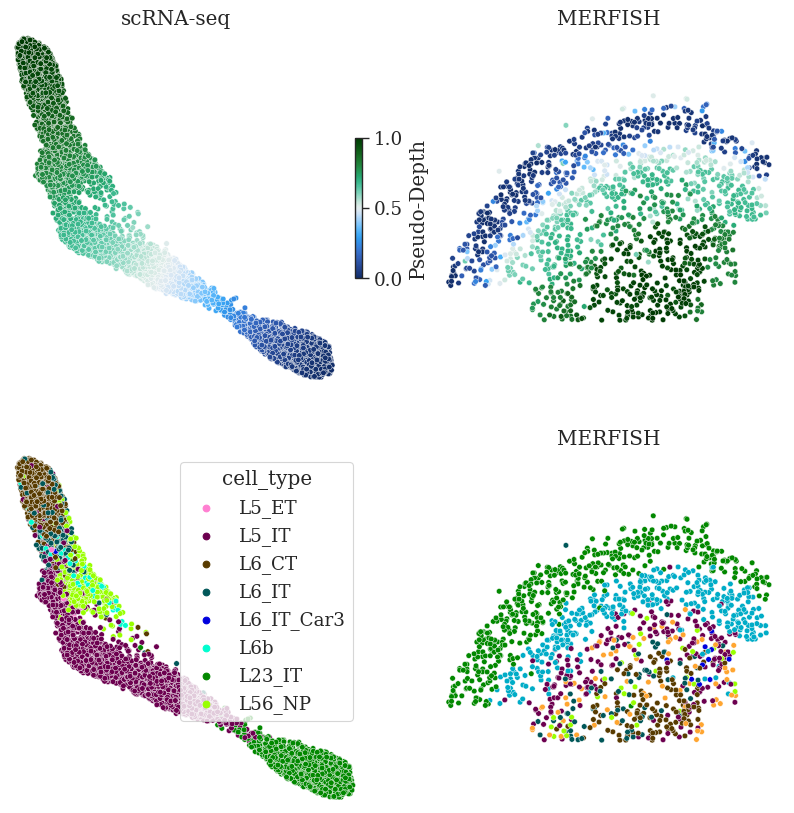

In [79]:
lim_arr = np.concatenate(
    [st_data_glut.obsm["FDL_COVET"], sc_data_glut.obsm["FDL_COVET"]], axis=0
)

delta = 1000
pre = 0.01
xmin = np.percentile(lim_arr[:, 0], pre) - delta
xmax = np.percentile(lim_arr[:, 0], 100 - pre) + delta
ymin = np.percentile(lim_arr[:, 1], pre) - delta
ymax = np.percentile(lim_arr[:, 1], 100 - pre) + delta

plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.title("scRNA-seq")
ax = sns.scatterplot(
    x=sc_data_glut.obsm["FDL_COVET"][:, 0],
    y=sc_data_glut.obsm["FDL_COVET"][:, 1],
    c=sc_data_glut.obsm["DC_COVET"][:, 0],
    s=16,
    cmap="cet_CET_D13",
    legend=False,
)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.axis("off")

norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap="cet_CET_D13", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
cbar = ax.figure.colorbar(sm, fraction=0.02, pad=0.04)
cbar.set_label("Pseudo-Depth")

plt.subplot(222)
plt.title("MERFISH")
sns.scatterplot(
    x=st_data_glut.obsm["spatial"][st_data_glut.obs["batch"] == "mouse1_slice10"][:, 1],
    y=-st_data_glut.obsm["spatial"][st_data_glut.obs["batch"] == "mouse1_slice10"][
        :, 0
    ],
    c=st_data_glut.obsm["DC_COVET"][st_data_glut.obs["batch"] == "mouse1_slice10"][
        :, 0
    ],
    s=16,
    cmap="cet_CET_D13",
    legend=False,
)
plt.axis("equal")
plt.axis("off")


plt.subplot(223)
sns.scatterplot(
    x=sc_data_glut.obsm["FDL_COVET"][:, 0],
    y=sc_data_glut.obsm["FDL_COVET"][:, 1],
    hue=sc_data_glut.obs["cell_type"],
    s=16,
    palette=cell_type_palette,
    legend=True,
)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.axis("off")

plt.subplot(224)
plt.title("MERFISH")
sns.scatterplot(
    x=st_data_glut.obsm["spatial"][st_data_glut.obs["batch"] == "mouse1_slice10"][:, 1],
    y=-st_data_glut.obsm["spatial"][st_data_glut.obs["batch"] == "mouse1_slice10"][
        :, 0
    ],
    legend=False,
    hue=st_data_glut.obs["cell_type"][st_data_glut.obs["batch"] == "mouse1_slice10"],
    s=16,
    palette=cell_type_palette,
)

plt.axis("equal")
plt.axis("off")

plt.show()

### Order cell and genes along scRNA-seq pseudo-depth

Cortical Layer genes from the Allen Brain Atlas:

In [80]:
L23_Genes = np.asarray(
    [
        "Tmem215",
        "Wfs1",
        "Ddit4l",
        "Stard8",
        "Pde7b",
        "Nova1",
        "Sowaha",
        "Rragd",
        "Ankrd6",
        "Rtn4rl1",
        "Palmd",
        "Prkg1",
        "Otof",
        "Dbp",
        "Fzd3",
        "Gsg1l",
        "Prex1",
        "Mapk4",
        "Mylk",
        "Prkca",
        "Kcnh3",
        "Mgat5b",
        "Kctd4",
        "Rabep2",
        "Hkdc1",
        "Tnfrsf19",
        "Rfx3",
        "Hap1",
        "Dgcr6",
        "Ube2e3",
        "Slc16a2",
        "Tac2",
        "Crispld1",
        "Dusp18",
        "Megf11",
        "Aqp4",
        "Slc9a9",
        "Vip",
        "Rgs8",
        "Egln1",
        "Dclk3",
        "Kitl",
        "Sfrp1",
        "Lhx2",
        "Gabra4",
        "Thpo",
        "Fam84a",
        "Cpne2",
        "Adamts18",
        "Syt17",
        "Trpc6",
        "Sytl2",
        "Cpne6",
        "Kcng3",
        "Lin7a",
        "Strada",
        "Stc1",
        "Pir",
        "Plk5",
        "Neurl1a",
        "Ar",
        "Rgs14",
        "Cacng3",
        "Smoc2",
    ]
)
L4_Genes = np.asarray(
    [
        "Rorb",
        "Rspo1",
        "Tspan11",
        "Unc5d",
        "Adam33",
        "Kcnab3",
        "Zdhhc2",
        "Zmat4",
        "Exph5",
        "Plxnd1",
        "Rora",
        "Pamr1",
        "Tmem145",
        "A830036E02Rik",
        "Sema7a",
        "Mtus2",
        "Tiam1",
        "Whrn",
        "Hs6st3",
        "Igfn1",
        "Plcxd2",
        "Tmem14a",
        "Gpr88",
        "Thsd7a",
        "Calb1",
        "Scrt1",
        "Gpr12",
        "Pcdh20",
        "B2m",
        "Scn1a",
        "Ankrd34c",
        "Sorcs1",
        "C1ra",
        "Coch",
        "Cd24a",
        "Sphkap",
        "Nacc2",
        "Osbpl5",
        "S100b",
        "Rims3",
        "Gtdc1",
        "Tmem65",
        "Gfpt2",
        "Ptpru",
        "Tdg",
        "Nrtn",
        "Rasgrf2",
        "Capn2",
        "Spag5",
        "AI593442",
        "Btbd3",
        "Lrrc4",
        "Kcnk2",
        "Fbxo34",
        "Dok4",
        "Anxa11",
        "Cacna1i",
        "Npnt",
        "Mafb",
        "Pdp1",
        "Cbln4",
        "Kcnc3",
        "Ccng1",
        "Pdzrn3",
    ]
)
L5_Genes = np.asarray(
    [
        "Etv1",
        "St6galnac5",
        "Tox",
        "Wnt7b",
        "Rspo2",
        "Tmeff1",
        "Slc6a7",
        "Fam84b",
        "Gnb4",
        "Ldb2",
        "Ntng1",
        "Hcn1",
        "Far2",
        "Chst8",
        "Kcnn2",
        "Scube1",
        "Deptor",
        "Ankrd34b",
        "Trib1",
        "Gpc1",
        "2900026A02Rik",
        "Fam20a",
        "Fam135b",
        "Rtn4rl2",
        "6430573F11Rik",
        "Trib2",
        "Ache",
        "Prmt2",
        "Sh3rf1",
        "Adcyap1",
        "Slc6a15",
        "Lhfp",
        "Grm8",
        "Arhgap12",
        "Akap12",
        "Nefh",
        "Fam189a1",
        "Dkkl1",
        "Cyb561",
        "Pcsk5",
        "Tmem200a",
        "Hrh3",
        "Clcn2",
        "D830030K20Rik",
        "Trpc4",
        "Pnkd",
        "Pde4a",
        "Wwox",
        "Tcerg1l",
        "Doc2a",
        "Ttc39b",
        "Rbp4",
        "Nrsn2",
        "Parm1",
        "Ust",
        "3632451O06Rik",
        "Thrb",
        "Scai",
        "Camk1g",
        "Pcsk1",
        "Kcnab1",
        "Ccdc85a",
        "Cacna2d2",
        "Cacna1h",
    ]
)
L6_Genes = np.asarray(
    [
        "Gprin3",
        "Foxp2",
        "Ighm",
        "Rgs9",
        "Ctgf",
        "Gng12",
        "Krt80",
        "Pde1b",
        "Tle4",
        "Sulf1",
        "Arhgap25",
        "Rell1",
        "Tbr1",
        "Cdh24",
        "Nfia",
        "Sdk2",
        "Sema5a",
        "Rprm",
        "Jup",
        "Sstr2",
        "Tle1",
        "Cplx3",
        "Thsd7b",
        "Gatm",
        "Col24a1",
        "Pik3r3",
        "Gxylt2",
        "Zfpm2",
        "Pde9a",
        "Col12a1",
        "Pdia5",
        "Col6a1",
        "B3galt2",
        "Ttc9b",
        "A830018L16Rik",
        "Csrp1",
        "Syt12",
        "Rai14",
        "Pde10a",
        "Fam163b",
        "Tmem163",
        "Chrna4",
        "Lypd6b",
        "Ephb1",
        "Ogfrl1",
        "Igsf21",
        "Limk1",
        "Slit1",
        "Dach1",
        "Gnal",
        "Bmp3",
        "Chst2",
        "Cdh18",
        "Tmem178",
        "Slc35f1",
        "Grik3",
        "Sema3e",
        "Arhgef10",
        "Slc44a1",
        "Pcp4",
        "Cdh9",
        "Plekhb1",
        "Cryab",
        "Col5a1",
    ]
)

cell by the pseudo-depth:

In [83]:
sc_data_glut_full = sc_data_glut.raw.to_adata()
sc_data_glut_full = sc_data_glut_full[:, (sc_data_glut_full.X > 0).sum(axis=0) > 5]

sc_data_glut_full.layers["log"] = np.log(sc_data_glut_full.X + 1)
sc.pp.highly_variable_genes(sc_data_glut_full, layer="log", n_top_genes=8192)

sc_data_glut_full.var["highly_variable"][
    np.intersect1d(st_data_glut.var_names, sc_data_glut_full.var_names)
] = True
sc_data_glut_full.var["highly_variable"][L23_Genes] = True
sc_data_glut_full.var["highly_variable"][L4_Genes] = True
sc_data_glut_full.var["highly_variable"][L5_Genes] = True
sc_data_glut_full.var["highly_variable"][L6_Genes] = True
sc_data_glut_full = sc_data_glut_full[:, sc_data_glut_full.var["highly_variable"]]


count_ps = normal_norm(
    np.log(sc_data_glut_full.X + 0.1)[
        np.argsort(sc_data_glut_full.obsm["DC_COVET"][:, 0]), :
    ]
)
count_ps_smooth = scipy.signal.convolve2d(
    count_ps, np.asarray([[1] * 32]).T / 32, mode="same"
)
count_ps_plot = scipy.signal.convolve2d(
    count_ps, np.asarray([[1] * 4]).T / 4, mode="same"
)

cell_ord = np.arange(count_ps_smooth.shape[0])
gene_ord = np.argsort(np.argmax(count_ps_smooth, axis=0))

Visualizing with a heatmap:

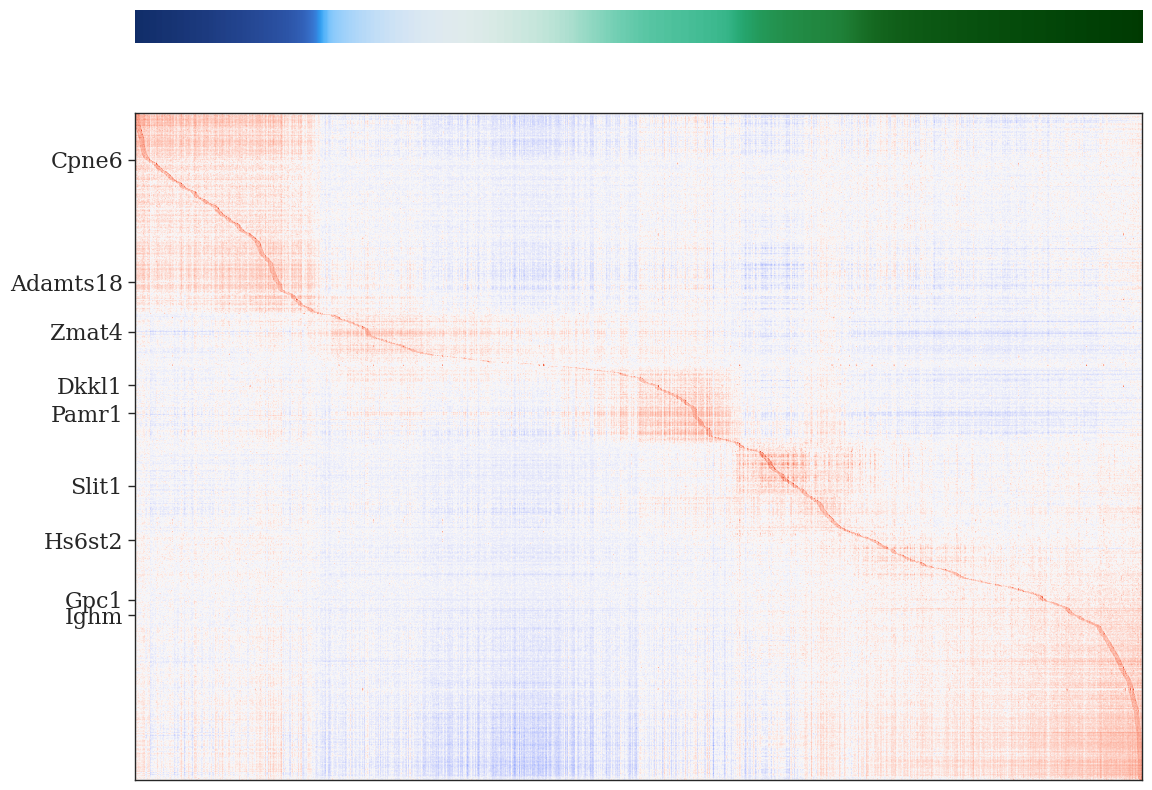

In [84]:
tick_genes = np.asarray(
    ["Cpne6", "Adamts18", "Pamr1", "Zmat4", "Dkkl1", "Hs6st2", "Slit1", "Ighm", "Gpc1"]
)
tick_genes_loc = np.asarray(
    [
        np.where(sc_data_glut_full.var_names[gene_ord] == tickgene)[0][0]
        for tickgene in tick_genes
    ]
)

norm = matplotlib.colors.Normalize(
    vmin=sc_data_glut_full.obsm["DC_COVET"][:, 0].min(),
    vmax=sc_data_glut_full.obsm["DC_COVET"][:, 0].max(),
)
diff_comp_colors = matplotlib.cm.get_cmap("cet_CET_D13")(
    norm(np.sort(sc_data_glut_full.obsm["DC_COVET"][:, 0]))
)

plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["axes.grid"] = False

fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=True,
    gridspec_kw={"height_ratios": [0.5, 10]},
    figsize=(13, 10),
)
ax[0].imshow(np.tile(diff_comp_colors[None, :, :], [1000, 1, 1]), aspect="auto")
ax[0].set_axis_off()

cm = ax[1].imshow(
    count_ps[cell_ord, :][:, gene_ord].T, cmap="cet_CET_D9", vmin=-2, vmax=2
)
ax[1].set_aspect("auto")
plt.yticks(tick_genes_loc, tick_genes)
plt.xticks([])
plt.show()

Showing where the genesets fall along the pseudo-space:

In [85]:
norm = matplotlib.colors.Normalize(0, 1)
L23_color = list(matplotlib.cm.jet(norm(0), bytes=True))  # [251, 220, 226, 255]
L4_color = list(matplotlib.cm.jet(norm(1 / 6), bytes=True))
L5_color = list(matplotlib.cm.jet(norm(2 / 6), bytes=True))
L6_color = list(matplotlib.cm.jet(norm(3 / 6), bytes=True))
NA_color = [255, 255, 255, 255]

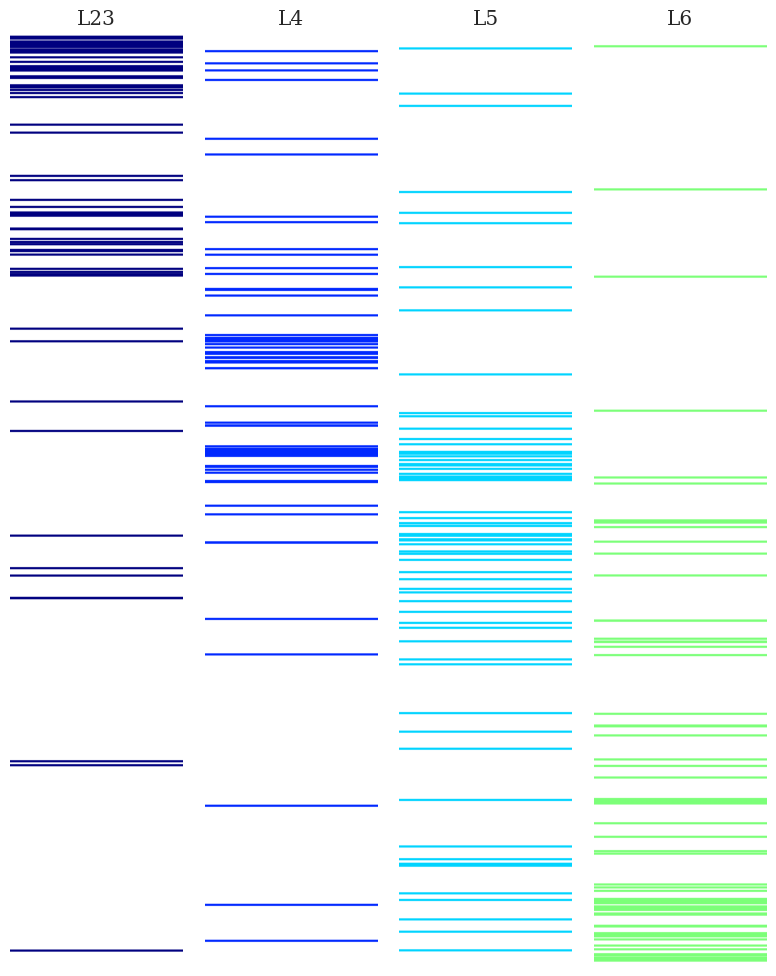

In [86]:
ind_layer = 0

plt.figure(figsize=(8, 10))
for layer_name, geneset in zip(
    ["L23", "L4", "L5", "L6"], [L23_Genes, L4_Genes, L5_Genes, L6_Genes]
):
    # for ind, layer in enumerate([L23_Genes, L4_Genes, L5_Genes, L6_Genes]):

    gene_layer = pd.DataFrame(
        ["NA"] * sc_data_glut_full.shape[-1],
        index=sc_data_glut_full.var_names,
        columns=["Layer"],
    ).T
    gene_layer.loc["Ord"] = [1000] * sc_data_glut_full.shape[-1]

    for gene in geneset:
        if gene_layer.loc["Ord"][gene] > np.where(geneset == gene)[0][0]:
            gene_layer.loc["Ord"][gene] = np.where(geneset == gene)[0][0]
            gene_layer.loc["Layer"][gene] = layer_name

    color_dict = {
        "L23": L23_color,
        "L4": L4_color,
        "L5": L5_color,
        "L6": L6_color,
        "NA": NA_color,
    }

    ordered_layer_annot = np.asarray(
        gene_layer[sc_data_glut_full.var_names[gene_ord]].loc["Layer"]
    )
    annot_ind = np.where(ordered_layer_annot != "NA")[0]

    for ind, val in enumerate(ordered_layer_annot):
        if val == "NA":
            if np.abs(annot_ind - ind).min() < 10:
                ordered_layer_annot[ind] = ordered_layer_annot[
                    annot_ind[np.argmin(np.abs(annot_ind - ind))]
                ]
    gene_layer_color = np.asarray([color_dict[l] for l in ordered_layer_annot]) / 255

    import matplotlib.patches

    legend_patches = []
    for key in color_dict.keys():
        legend_patches.append(
            matplotlib.patches.Patch(color=np.asarray(color_dict[key]) / 255, label=key)
        )

    ord_genes = sc_data_glut_full.var_names[gene_ord]
    ord_genes = np.asarray(
        [gene for gene in ord_genes if gene in sc_data_glut.var_names]
    )

    plt.rcParams["ytick.labelsize"] = 16
    plt.rcParams["axes.grid"] = False

    plt.subplot(1, 4, 1 + ind_layer)
    plt.imshow(np.tile(gene_layer_color[:, None, :], [1, 1000, 1]), aspect="auto")
    plt.axis("off")
    plt.title(layer_name)

    ind_layer = ind_layer + 1
    # savefig('/fscratch/havivd/ENVI_Figures/CortexMerFISH/' + layer_name + '_Genes.png')
plt.tight_layout()
plt.show()

And their expression along cells in pseudo-depth:

In [87]:
sc_data_glut_full.layers["zscore"] = normal_norm(np.log(sc_data_glut_full.X + 0.1))
st_data_glut.layers["zscore"] = normal_norm(np.log(st_data_glut.X + 0.1))

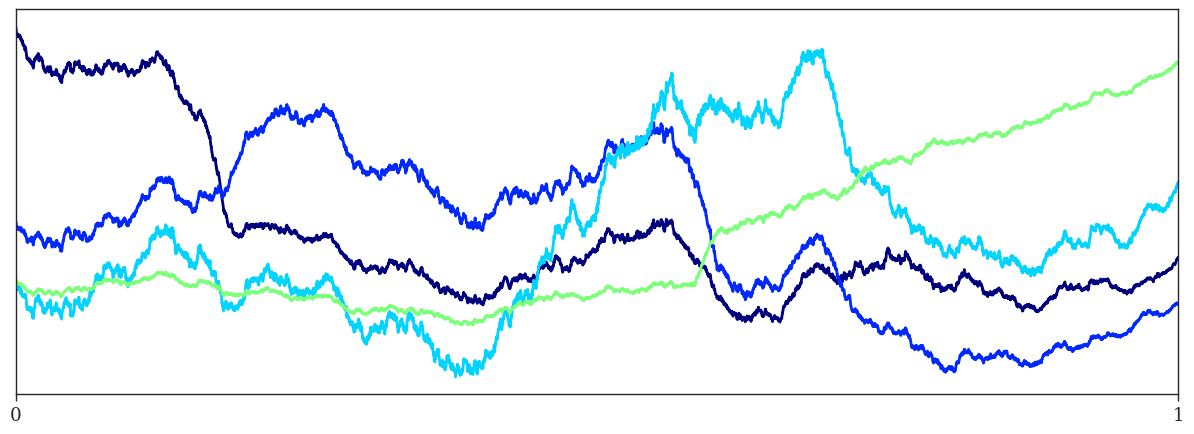

In [88]:
smooth_dim = 128

L2Exp = scipy.signal.convolve(
    sc_data_glut_full[np.argsort(sc_data_glut_full.obsm["DC_COVET"][:, 0])][
        :, L23_Genes
    ]
    .layers["zscore"]
    .mean(axis=1),
    np.asarray([1] * smooth_dim).T / smooth_dim,
    mode="valid",
)
L4Exp = scipy.signal.convolve(
    sc_data_glut_full[np.argsort(sc_data_glut_full.obsm["DC_COVET"][:, 0])][:, L4_Genes]
    .layers["zscore"]
    .mean(axis=1),
    np.asarray([1] * smooth_dim).T / smooth_dim,
    mode="valid",
)
L5Exp = scipy.signal.convolve(
    sc_data_glut_full[np.argsort(sc_data_glut_full.obsm["DC_COVET"][:, 0])][:, L5_Genes]
    .layers["zscore"]
    .mean(axis=1),
    np.asarray([1] * smooth_dim).T / smooth_dim,
    mode="valid",
)
L6Exp = scipy.signal.convolve(
    sc_data_glut_full[np.argsort(sc_data_glut_full.obsm["DC_COVET"][:, 0])][:, L6_Genes]
    .layers["zscore"]
    .mean(axis=1),
    np.asarray([1] * smooth_dim).T / smooth_dim,
    mode="valid",
)

scipy.stats.pearsonr(L2Exp, L4Exp)

plt.figure(figsize=(15, 5))

plt.plot(normal_norm(L2Exp, 3), c=np.asarray(L23_color) / 255, linewidth=2)
plt.plot(normal_norm(L4Exp, 3), c=np.asarray(L4_color) / 255, linewidth=2)
plt.plot(normal_norm(L5Exp, 3), c=np.asarray(L5_color) / 255, linewidth=2)
plt.plot(normal_norm(L6Exp, 3), c=np.asarray(L6_color) / 255, linewidth=2)
plt.xticks([0, L2Exp.shape[0]], ["0", "1"])
plt.yticks([])


plt.xlim([0, L2Exp.shape[0]])

plt.show()

### We try and replicate this results with just the spatial data alone:

Calculating 'true-depth' for the MERFISH data with DC on their 2D spatial coordinates:

In [89]:
st_data_glut.obsm["DC_COORD"] = np.zeros_like(st_data_glut.obsm["DC_COVET"])
for batch in list(set(st_data_glut.obs["batch"])):
    st_data_glut.obsm["DC_COORD"][st_data_glut.obs["batch"] == batch] = ZeroOneNorm(
        np.asarray(
            run_diffusion_maps(
                np.asarray(
                    st_data_glut[st_data_glut.obs["batch"] == batch].obsm["spatial"]
                ),
                k=30,
            )["EigenVectors"]
        )[:, 1:]
    )

Determining nearest neighbor graph...
Determining nearest neighbor graph...
Determining nearest neighbor graph...
Determining nearest neighbor graph...
Determining nearest neighbor graph...
Determining nearest neighbor graph...


Again, DC direction is arbitrary, so we flip the DC on slices where its backwards:
- should go from shallow (blue) to deep (pink)

In [90]:
batch_sign = {
    "mouse1_slice10": -1,
    "mouse1_slice31": 1,
    "mouse1_slice1": -1,
    "mouse1_slice21": 1,
    "mouse1_slice40": -1,
    "mouse1_slice50": 1,
}

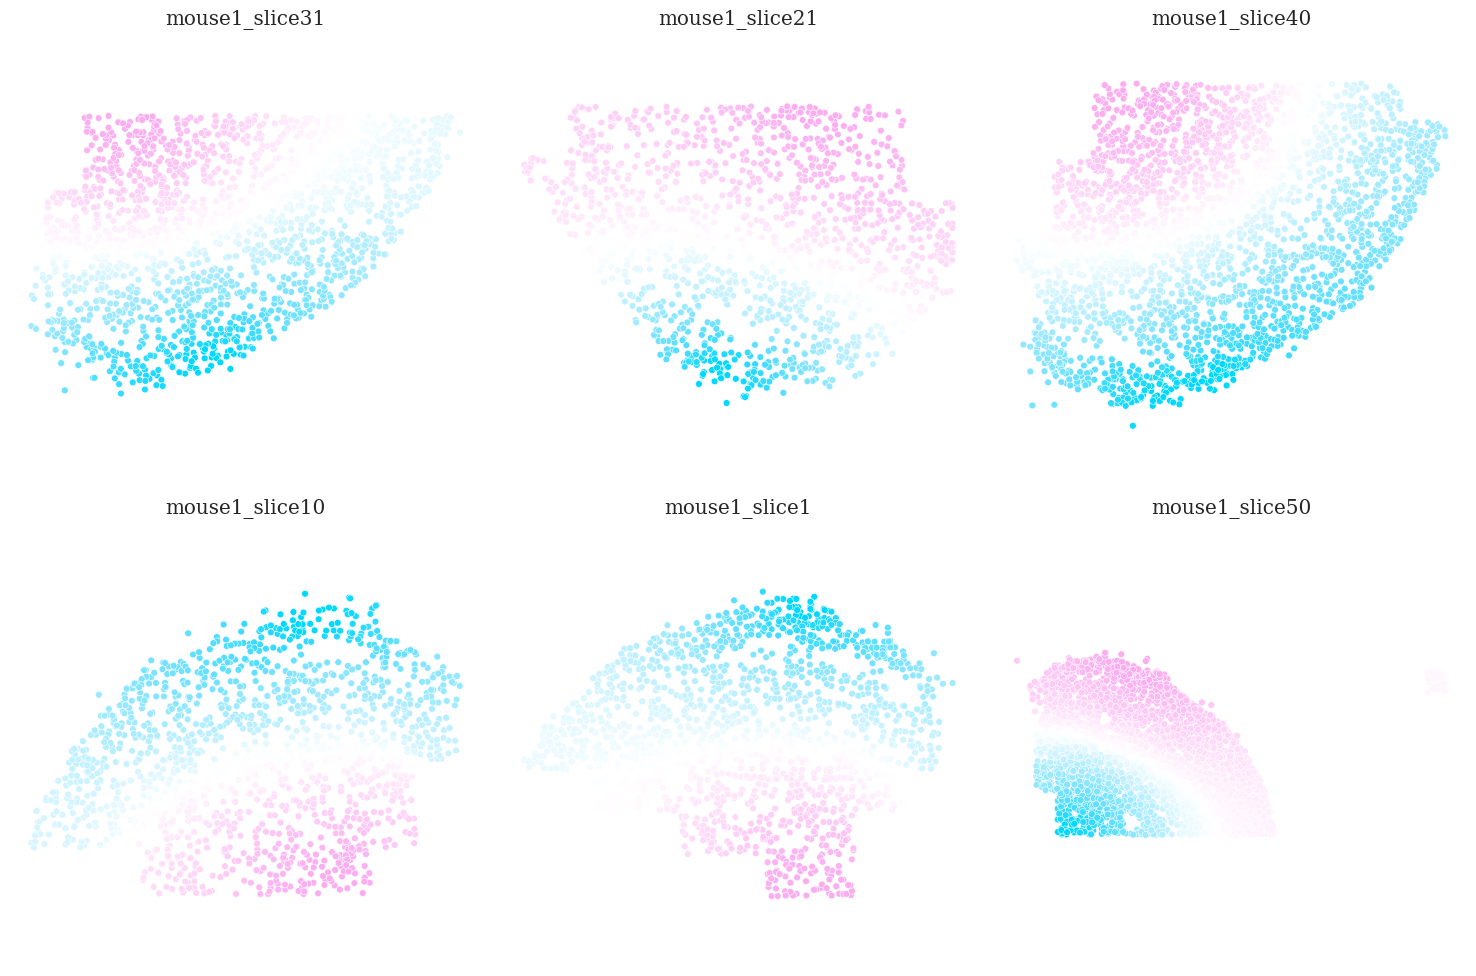

In [91]:
for batch in list(set(st_data_glut.obs["batch"])):
    st_data_glut.obsm["DC_COORD"][st_data_glut.obs["batch"] == batch] = ZeroOneNorm(
        st_data_glut.obsm["DC_COORD"][st_data_glut.obs["batch"] == batch]
        * batch_sign[batch]
    )


plt.figure(figsize=(15, 10))

for ind, batch in enumerate(list(set(st_data_glut.obs["batch"]))):
    plt.subplot(2, 3, 1 + ind)
    sns.scatterplot(
        x=st_data_glut.obsm["spatial"][st_data_glut.obs["batch"] == batch][:, 1],
        y=-st_data_glut.obsm["spatial"][st_data_glut.obs["batch"] == batch][:, 0],
        legend=False,
        c=st_data_glut.obsm["DC_COORD"][:, 1][st_data_glut.obs["batch"] == batch],
        vmin=0,
        vmax=1,
        s=24,
        cmap="cet_CET_D10",
    )  # , palette = cell_type_palette)
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    plt.axis("equal")
    plt.axis("off")
    plt.title(batch)

plt.tight_layout()
plt.show()
# savefig('/fscratch/havivd/EN

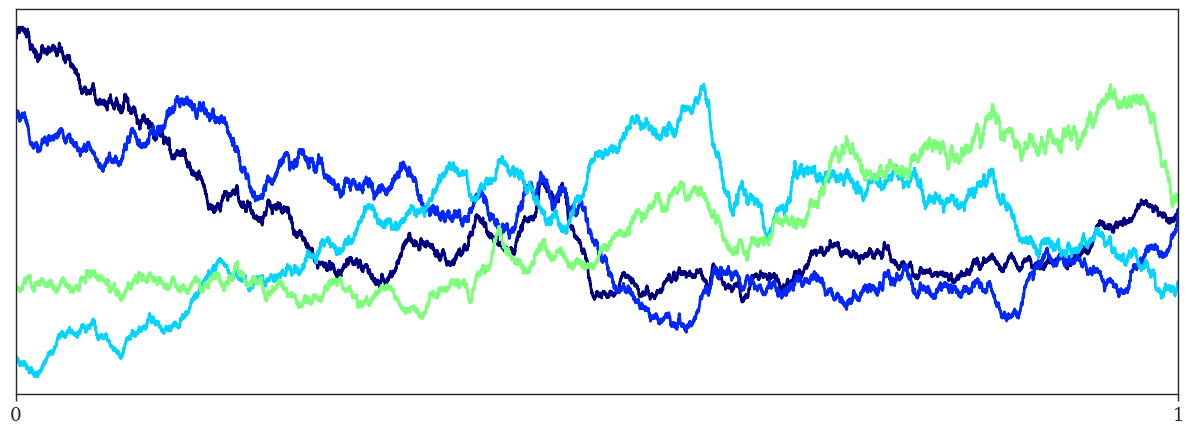

In [92]:
L23_Genes_fish = np.intersect1d(
    st_data.var_names, L23_Genes
)  # np.asarray([gene for gene in gene_lists[0] if gene in st_data.var_names])[:10]
L4_Genes_fish = np.intersect1d(
    st_data.var_names, L4_Genes
)  # np.asarray([gene for gene in gene_lists[1] if gene in st_data.var_names])[:10]
L5_Genes_fish = np.intersect1d(
    st_data.var_names, L5_Genes
)  # np.asarray([gene for gene in gene_lists[2] if gene in st_data.var_names])[:10]
L6_Genes_fish = np.intersect1d(
    st_data.var_names, L6_Genes
)  # np.asarray([gene for gene in gene_lists[3] if gene in st_data.var_names])[:10]


smooth_dim = 256

L2Exp = scipy.signal.convolve(
    st_data_glut[np.argsort(st_data_glut.obsm["DC_COORD"][:, 1])][:, L23_Genes_fish]
    .layers["zscore"]
    .mean(axis=1),
    np.asarray([1] * smooth_dim).T / smooth_dim,
    mode="valid",
)
L4Exp = scipy.signal.convolve(
    st_data_glut[np.argsort(st_data_glut.obsm["DC_COORD"][:, 1])][:, L4_Genes_fish]
    .layers["zscore"]
    .mean(axis=1),
    np.asarray([1] * smooth_dim).T / smooth_dim,
    mode="valid",
)
L5Exp = scipy.signal.convolve(
    st_data_glut[np.argsort(st_data_glut.obsm["DC_COORD"][:, 1])][:, L5_Genes_fish]
    .layers["zscore"]
    .mean(axis=1),
    np.asarray([1] * smooth_dim).T / smooth_dim,
    mode="valid",
)
L6Exp = scipy.signal.convolve(
    st_data_glut[np.argsort(st_data_glut.obsm["DC_COORD"][:, 1])][:, L6_Genes_fish]
    .layers["zscore"]
    .mean(axis=1),
    np.asarray([1] * smooth_dim).T / smooth_dim,
    mode="valid",
)

scipy.stats.pearsonr(L2Exp, L4Exp)


plt.figure(figsize=(15, 5))

plt.plot(normal_norm(L2Exp, 3.5), c=np.asarray(L23_color) / 255, linewidth=2)
plt.plot(normal_norm(L4Exp, 3.5), c=np.asarray(L4_color) / 255, linewidth=2)
plt.plot(normal_norm(L5Exp, 3.5), c=np.asarray(L5_color) / 255, linewidth=2)
plt.plot(normal_norm(L6Exp, 3.5), c=np.asarray(L6_color) / 255, linewidth=2)
plt.xticks([0, L2Exp.shape[0]], ["0", "1"])
plt.yticks([])


plt.xlim([0, L2Exp.shape[0]])

# savefig('/fscratch/havivd/ENVI_Figures/CortexMerFISH/All_layer_depth_fish.png')
plt.show()

# ENVI imputation on Spatial Data

- We can also check the imputation of ENVI on the MERFISH to see if it matches the cortical depth prediction:

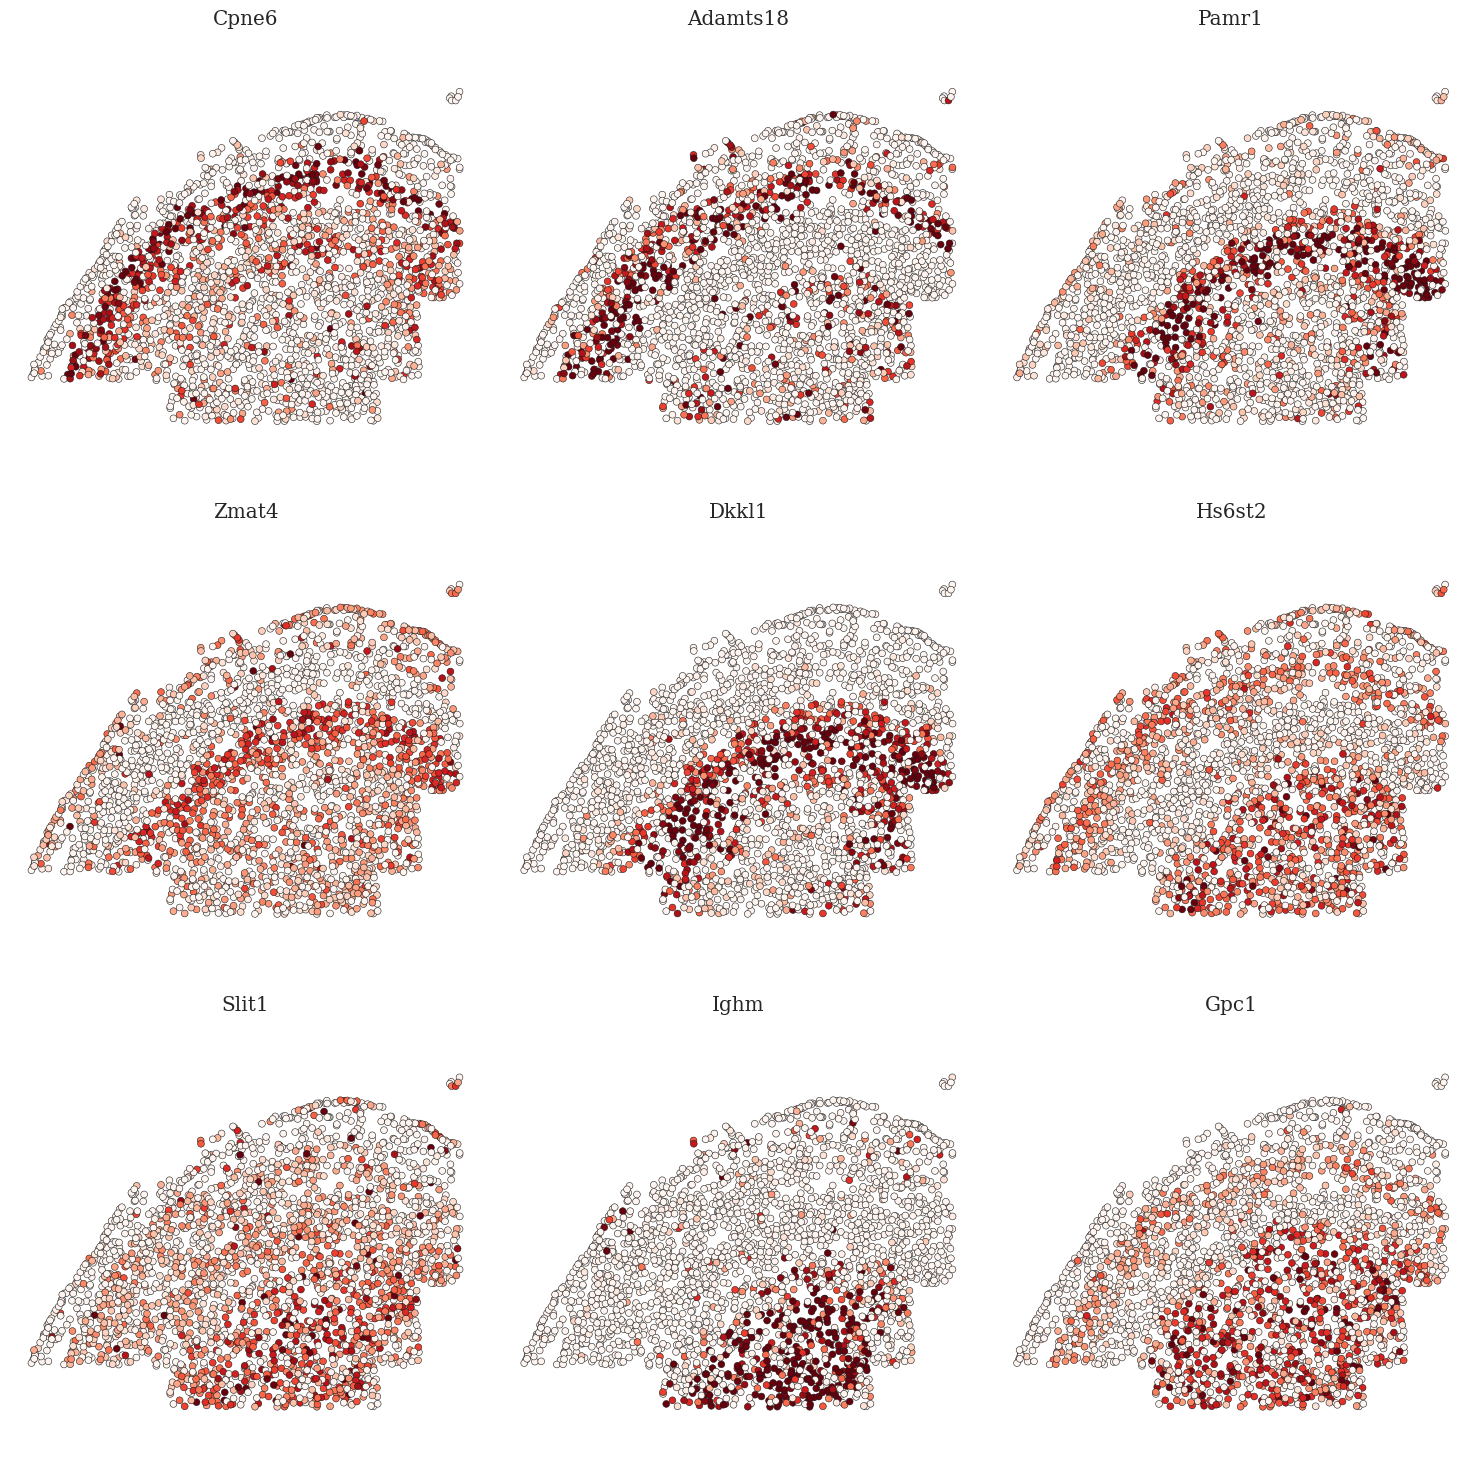

In [93]:
plt.figure(figsize=(15, 15))

for ind, gene in enumerate(tick_genes):
    plt.subplot(3, 3, 1 + ind)

    sns.scatterplot(
        x=st_data.obsm["spatial"][st_data.obs["batch"] == "mouse1_slice10"][:, 1],
        y=-st_data.obsm["spatial"][st_data.obs["batch"] == "mouse1_slice10"][:, 0],
        legend=False,
        c=normal_norm(
            np.log(
                st_data[st_data.obs["batch"] == "mouse1_slice10"].obsm["imputation"][
                    gene
                ]
                + 0.1
            )
        ),
        cmap="Reds",
        vmax=2,
        vmin=0,
        s=24,
        edgecolor="k",
    )  # , palette = cell_type_palette)
    plt.title(gene)
    plt.axis("equal")
    plt.axis("off")
    plt.tight_layout()
plt.show()